# Импорт необходимых библиотек

In [47]:
# Импортируем необходимые библиотеки
import torch  # Для использования GPU (если доступен) и работы с тензорами
import numpy as np  # Для работы с массивами и математическими операциями
import matplotlib.pyplot as plt  # Для построения графиков
import tkinter as tk  # Для создания графического интерфейса
from tkinter import messagebox  # Для отображения диалоговых окон в графическом интерфейсе
import gymnasium as gym  # Для создания и использования среды OpenAI Gym
from gymnasium import spaces  # Для создания пространств действий и наблюдений
from stable_baselines3 import PPO  # Для использования алгоритма Proximal Policy Optimization (PPO)
from stable_baselines3.common.vec_env import DummyVecEnv  # Для создания векторизированной среды



# Настройка среды

In [48]:
class TicTacToeEnv(gym.Env):
    def __init__(self, size):
        # Инициализация среды игры "Крестики-нолики" с заданным размером поля
        self.size = size  # Устанавливаем размер поля (например, 3 для поля 3x3)
        self.board = np.zeros((self.size, self.size), dtype=int)  # Создаем пустое игровое поле размера size x size, заполненное нулями
        self.current_player = 1  # Текущий игрок, начинаем с первого игрока (1 - крестики, 2 - нолики)

        # Определяем пространство действий и наблюдений для среды
        # Действия - дискретное пространство с количеством действий равным количеству клеток на поле (size * size)
        self.action_space = gym.spaces.Discrete(self.size * self.size)
        # Наблюдения - двумерное пространство, где каждая клетка может быть пустой (0), занята крестиком (1) или ноликом (2)
        self.observation_space = gym.spaces.Box(low=0, high=2, shape=(self.size, self.size), dtype=int)

    def reset(self, seed=None, options=None):
        # Сброс состояния игры до начального состояния
        super().reset(seed=seed)  # Сброс с использованием возможного случайного зерна (seed)
        self.board = np.zeros((self.size, self.size), dtype=int)  # Очищаем игровое поле (все клетки становятся пустыми)
        self.current_player = 1  # Текущий игрок снова становится первым игроком (крестики)
        return self.board, {}  # Возвращаем новое состояние игрового поля и пустой словарь (совместимость с Gym API)

    def step(self, action):
        # Выполняем один шаг в среде (ход игрока)
        row, col = divmod(action, self.size)  # Преобразуем действие в координаты (строка, столбец) на игровом поле
        if self.board[row, col] != 0:
            # Если клетка уже занята (некорректный ход), возвращаем текущее состояние, штраф -10, игра окончена
            return self.board, -10, True, False, {}

        self.board[row, col] = self.current_player  # Устанавливаем ход текущего игрока на игровое поле
        reward = 0  # Инициализируем награду
        terminated = False  # Инициализируем флаг завершения игры

        if self.check_winner(self.current_player):
            # Если текущий игрок выиграл, награда 1, игра завершена
            reward = 1
            terminated = True
        elif len(self.available_actions()) == 0:
            # Если не осталось доступных ходов (ничья), награда 0.5, игра завершена
            reward = 0.5
            terminated = True
        else:
            # Проверяем, заблокировал ли текущий игрок возможную выигрышную линию противника
            if self.check_block_opponent():
                reward += 0.2  # Увеличенная награда за блокировку линии противника

            self.current_player = 3 - self.current_player  # Смена текущего игрока (переключение между 1 и 2)

            # Проверяем, пропустил ли текущий игрок возможность блокировки
            if self.check_missed_block():
                reward -= 0.2  # Увеличенный штраф за пропущенную возможность блокировки

        return self.board, reward, terminated, False, {}  # Возвращаем текущее состояние, награду, флаги завершения и пустой словарь

    def available_actions(self):
        # Возвращаем список доступных действий (пустые клетки на игровом поле)
        return [(i, j) for i in range(self.size) for j in range(self.size) if self.board[i, j] == 0]

    def check_winner(self, player):
        # Проверка наличия выигрышной комбинации для указанного игрока
        for i in range(self.size):
            # Проверяем строки и столбцы
            if np.all(self.board[i, :] == player) or np.all(self.board[:, i] == player):
                return True
        # Проверяем диагонали
        if np.all(np.diag(self.board) == player) or np.all(np.diag(np.fliplr(self.board)) == player):
            return True
        return False

    def check_block_opponent(self):
        # Проверка необходимости блокировки линии противника
        opponent = 3 - self.current_player  # Определяем противника (если текущий игрок 1, то противник 2 и наоборот)
        for i in range(self.size):
            for j in range(self.size):
                if self.board[i, j] == opponent:
                    # Проверяем возможные линии из четырех крестиков
                    if self.check_line_block(i, j, opponent):
                        return True
        return False

    def check_line_block(self, row, col, opponent):
        # Проверка на наличие линии из четырех крестиков противника
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]  # Определяем направления для проверки (горизонтально, вертикально, диагонали)
        for dr, dc in directions:
            count = 0
            for k in range(-3, 4):  # Проверяем ячейки в пределах от -3 до +3 от текущей ячейки (в обе стороны)
                r, c = row + k * dr, col + k * dc
                if 0 <= r < self.size and 0 <= c < self.size:  # Убедимся, что ячейка находится в пределах игрового поля
                    if self.board[r, c] == opponent:
                        count += 1  # Увеличиваем счетчик, если ячейка занята противником
                    elif self.board[r, c] == 0:
                        if count == 4:  # Если нашли линию из четырех противника, требуется блокировка
                            return True
                        count = 0
        return False

    def check_missed_block(self):
        # Логика для проверки пропущенной возможности блокировки
        opponent = 3 - self.current_player  # Определяем противника
        for i in range(self.size):
            for j in range(self.size):
                if self.board[i, j] == 0:  # Проверяем пустые ячейки
                    self.board[i, j] = opponent  # Временно устанавливаем ход противника
                    if self.check_winner(opponent):  # Проверяем, есть ли выигрышная комбинация
                        self.board[i, j] = 0  # Восстанавливаем ячейку
                        return True  # Найдена пропущенная возможность блокировки
                    self.board[i, j] = 0  # Восстанавливаем ячейку
        return False



# Функция тренировки агента и построение сглаженной кривой обучения

In [49]:
def train_agents(size, episodes):
    # Функция для обучения агентов игры "Крестики-нолики" с заданным размером поля и количеством эпизодов
    env = DummyVecEnv([lambda: TicTacToeEnv(size)])  # Создаем векторизированную среду для обучения агентов

    # Инициализация первого агента с использованием алгоритма Proximal Policy Optimization (PPO)
    # Используем GPU (если доступен) для ускорения обучения
    agent1 = PPO("MlpPolicy", env, verbose=1, device="cuda" if torch.cuda.is_available() else "cpu")
    # Инициализация второго агента аналогично первому
    agent2 = PPO("MlpPolicy", env, verbose=1, device="cuda" if torch.cuda.is_available() else "cpu")
    
    # Списки для сохранения истории побед каждого агента
    win_history_agent1 = []
    win_history_agent2 = []

    # Основной цикл обучения
    for episode in range(1, episodes + 1):
        obs = env.reset()  # Сбрасываем среду и получаем начальное наблюдение
        done = [False]  # Флаг завершения эпизода

        # Цикл выполнения шагов в эпизоде
        while not all(done):
            action1, _ = agent1.predict(obs)  # Первый агент предсказывает действие на основе текущего наблюдения
            obs, reward1, done, info = env.step(action1)  # Выполняем действие и получаем новые наблюдения и награды
            if all(done):  # Если эпизод завершен, сохраняем результат и выходим из цикла
                win_history_agent1.append(reward1[0])
                win_history_agent2.append(-reward1[0])
                break

            action2, _ = agent2.predict(obs)  # Второй агент предсказывает действие на основе текущего наблюдения
            obs, reward2, done, info = env.step(action2)  # Выполняем действие и получаем новые наблюдения и награды
            if all(done):  # Если эпизод завершен, сохраняем результат
                win_history_agent2.append(reward2[0])
                win_history_agent1.append(-reward2[0])

        # Каждые 1000 эпизодов выводим прогресс обучения
        if episode % 1000 == 0:
            print(f'Эпизод {episode}/{episodes} завершен.')

    # Сохраняем обученные модели агентов
    agent1.save("agent1_ppo_3x3")
    agent2.save("agent2_ppo_3x3")

    # Возвращаем обученных агентов и историю их побед
    return agent1, agent2, win_history_agent1, win_history_agent2



# Построение кривой обучения

In [50]:
def plot_learning_curve(win_history, agent_name="Агент"):
    # Функция для построения графика кривой обучения агента
    
    window_size = 100  # Определяем размер окна для скользящего среднего
    # Вычисляем скользящее среднее значений в истории побед
    smoothed_win_history = np.convolve(win_history, np.ones(window_size) / window_size, mode='valid')
    
    # Строим график кривой обучения
    plt.plot(smoothed_win_history, label=f"{agent_name}: Скользящее среднее выигрышей")
    
    # Устанавливаем метку по оси X
    plt.xlabel('Эпизоды')
    # Устанавливаем метку по оси Y
    plt.ylabel('Средний результат (10 - победа, 5 - ничья, 0 - поражение)')
    
    # Устанавливаем заголовок графика
    plt.title(f'Кривая обучения для {agent_name}')
    
    # Добавляем легенду на график
    plt.legend()
    
    # Отображаем график
    plt.show()


# Инициализация агента и обучение на поле размером 3х3

Using cuda device
Using cuda device
Эпизод 1000/10000 завершен.
Эпизод 2000/10000 завершен.
Эпизод 3000/10000 завершен.
Эпизод 4000/10000 завершен.
Эпизод 5000/10000 завершен.
Эпизод 6000/10000 завершен.
Эпизод 7000/10000 завершен.
Эпизод 8000/10000 завершен.
Эпизод 9000/10000 завершен.
Эпизод 10000/10000 завершен.
Отображение графика обучения агента 1


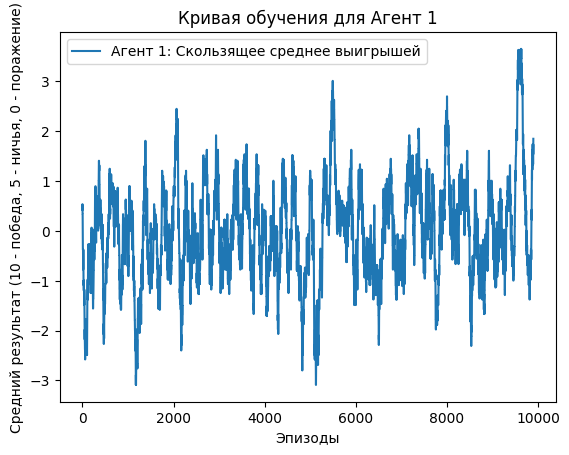

Отображение графика обучения агента 2


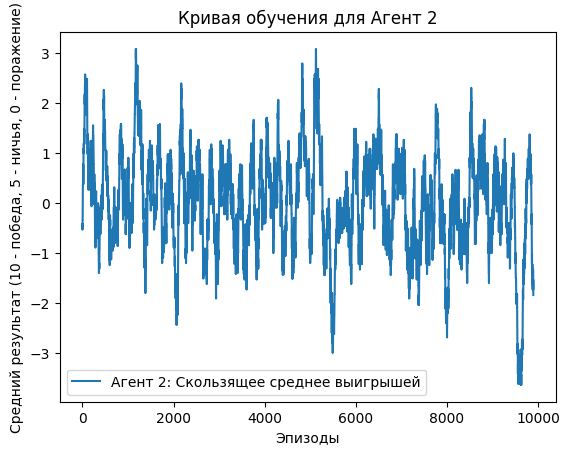

In [51]:
def main():
    # Главная функция программы, запускающая обучение агентов и отображение графиков

    size = 3  # Устанавливаем размер игрового поля (например, 3 для поля 3x3)
    
    episodes = 10000  # Устанавливаем количество эпизодов для обучения агентов
    
    # Обучаем агентов и получаем историю побед для каждого из них
    agent1, agent2, win_history_agent1, win_history_agent2 = train_agents(size=size, episodes=episodes)
    
    if win_history_agent1:
        # Если у первого агента есть история побед, отображаем график его обучения
        print("Отображение графика обучения агента 1")
        plot_learning_curve(win_history_agent1, "Агент 1")

    if win_history_agent2:
        # Если у второго агента есть история побед, отображаем график его обучения
        print("Отображение графика обучения агента 2")
        plot_learning_curve(win_history_agent2, "Агент 2")

if __name__ == "__main__":
    # Запускаем основную функцию, если скрипт выполняется напрямую
    main()


# Запуск игры на поле произвольного размера

In [56]:
class TicTacToeGUI:
    def __init__(self, root, size, agent1, agent2=None):
        # Инициализация графического интерфейса для игры "Крестики-нолики"
        self.root = root  # Корневой элемент графического интерфейса
        self.size = size  # Размер игрового поля
        self.agent1 = agent1  # Агент 1, который будет играть против человека или другого агента
        self.agent2 = agent2  # (опционально) Агент 2, если требуется игра между двумя агентами
        self.game = TicTacToeEnv(size)  # Создаем экземпляр среды игры "Крестики-нолики"
        self.game.reset()  # Сбрасываем игру до начального состояния

        # Создаем кнопки для игрового поля
        self.buttons = [[None for _ in range(size)] for _ in range(size)]
        self.create_board()  # Вызываем функцию для создания игрового поля
        self.current_agent = agent1  # Устанавливаем текущего агента (по умолчанию агент 1)
        self.player_turn = True  # Флаг, указывающий, что сейчас ходит человек

    def create_board(self):
        # Функция для создания игрового поля (кнопки) в графическом интерфейсе
        for i in range(self.size):
            for j in range(self.size):
                button = tk.Button(self.root, text=" ", font='Arial 20', width=5, height=2,
                                   command=lambda row=i, col=j: self.human_move(row, col))
                button.grid(row=i, column=j)  # Размещаем кнопку в сетке
                self.buttons[i][j] = button  # Сохраняем ссылку на кнопку

    def human_move(self, row, col):
        # Обработка хода человека
        if self.game.board[row, col] == 0 and self.player_turn:
            print(f"Player moves to: ({row}, {col})")
            state, reward, done, truncated, info = self.game.step((row * self.size) + col)
            self.update_board()  # Обновляем отображение игрового поля
            print(f"step returns: {state}, {reward}, {done}, {truncated}, {info}")
            if done:
                if self.check_game_over():  # Проверяем, завершена ли игра
                    return
            self.player_turn = False  # Передаем ход агенту
            self.agent_move()

    def agent_move(self):
        # Обработка хода агента
        if self.current_agent and not self.player_turn:
            print("Agent's move")
            state = self.game.board.reshape((1, self.size, self.size))  # Преобразуем в нужную форму
            
            valid_move = False
            while not valid_move:
                # Обрезаем или масштабируем доску до размера 3x3, чтобы соответствовать модели
                resized_state = state[:, :3, :3]  # Временно обрезаем до 3x3 для предсказания
                action, _ = self.current_agent.predict(resized_state)  # Агент предсказывает действие
                row, col = divmod(action, self.size)
                
                if (row, col) in self.game.available_actions():  # Проверяем валидность хода
                    valid_move = True
                    print(f"Agent moves to: ({row}, {col})")
                    state, reward, done, truncated, info = self.game.step(action)
                    self.update_board()  # Обновляем отображение игрового поля
                    print(f"step returns: {state}, {reward}, {done}, {truncated}, {info}")
                    if done:
                        if self.check_game_over():  # Проверяем, завершена ли игра
                            return
                    self.player_turn = True  # Передаем ход человеку
                else:
                    print(f"Invalid move by agent: ({row}, {col}), retrying...")

    def update_board(self):
        # Обновление отображения игрового поля в графическом интерфейсе
        for i in range(self.size):
            for j in range(self.size):
                if self.game.board[i, j] == 1:
                    self.buttons[i][j].config(text='X')  # Отображаем крестики
                elif self.game.board[i, j] == 2:
                    self.buttons[i][j].config(text='O')  # Отображаем нолики
                else:
                    self.buttons[i][j].config(text=' ')  # Очищаем клетку

    def check_game_over(self):
        # Проверка, завершена ли игра, и отображение сообщения
        if self.game.check_winner(1):
            print("Player 1 wins")
            tk.messagebox.showinfo("Game Over", "Поздравляем! Игрок 1 (X) победил!")
            self.reset_game()  # Сбрасываем игру
            return True
        elif self.game.check_winner(2):
            print("Agent wins")
            tk.messagebox.showinfo("Game Over", "Агент (O) победил!")
            self.reset_game()  # Сбрасываем игру
            return True
        elif len(self.game.available_actions()) == 0:
            print("Draw")
            tk.messagebox.showinfo("Game Over", "Ничья!")
            self.reset_game()  # Сбрасываем игру
            return True
        return False

    def reset_game(self):
        # Сброс состояния игры и обновление игрового поля
        print("Resetting game")
        self.game.reset()
        self.update_board()

def start_game(agent1):
    # Функция для запуска графического интерфейса и начала игры
    size = int(input("Введите размер поля для игры (например, 3 для 3x3): "))
    root = tk.Tk()  # Создаем корневой элемент графического интерфейса
    root.title("Крестики-Нолики")  # Устанавливаем заголовок окна
    app = TicTacToeGUI(root, size, agent1)  # Создаем экземпляр класса TicTacToeGUI
    print("Запуск графического интерфейса")
    root.mainloop()  # Запускаем основной цикл графического интерфейса

# Загрузка обученной модели агента 1
agent1 = PPO.load("agent1_ppo_3x3.zip")

# Запуск игры
start_game(agent1)




Запуск графического интерфейса
Player moves to: (2, 2)
step returns: [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]], 0, False, False, {}
Agent's move
Agent moves to: ([1], [0])
step returns: [[0 0 0 0 0]
 [2 0 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]], 0, False, False, {}
Player moves to: (1, 3)
step returns: [[0 0 0 0 0]
 [2 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]], 0, False, False, {}
Agent's move
Agent moves to: ([0], [3])
step returns: [[0 0 0 2 0]
 [2 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]], 0, False, False, {}
Player moves to: (0, 4)
step returns: [[0 0 0 2 1]
 [2 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]], 0, False, False, {}
Agent's move
Agent moves to: ([0], [0])
step returns: [[2 0 0 2 1]
 [2 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]], 0, False, False, {}
Player moves to: (3, 1)
step returns: [[2 0 0 2 1]
 [2 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]], -0.2, False, False, {}
Agent's move
Invalid move by agent: ([1], [